# Map 2 - Unconformity

This map is also from Bennison et al. (2011).

In [1]:
# Import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

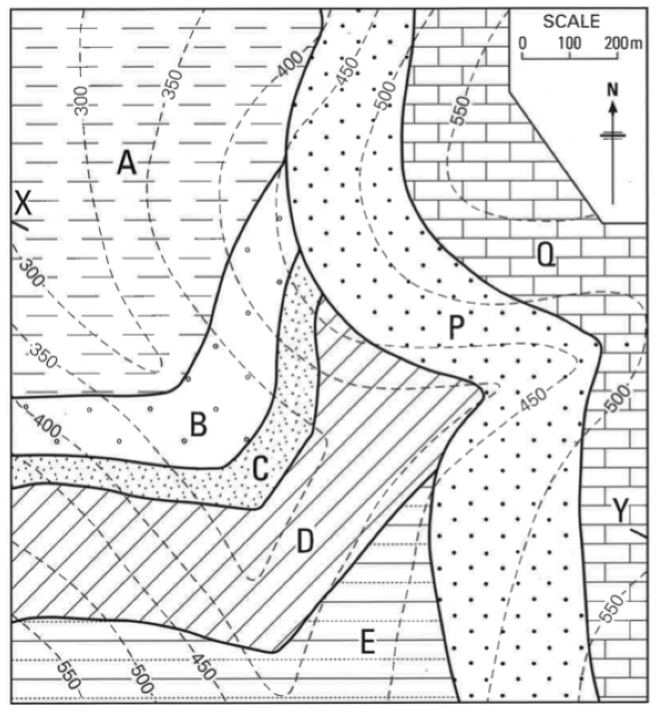

In [2]:
# Display map
img = mpimg.imread('map2.png')
plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.tight_layout()

In [3]:
# Import other required libraries
import geopandas as gpd
import rasterio
import gemgis as gg
import os

In [4]:
# Get current directory
current_directory = os.getcwd()

In [5]:
# Read the topographic contours
topo = gpd.read_file(filename = current_directory+"/contours/contours.shp")
topo.head()

,X,Y,Z,geometry
0,4.47,954.44,300,POINT (4.473 954.439)
1,17.91,929.65,300,POINT (17.905 929.649)
2,34.36,908.75,300,POINT (34.359 908.749)
3,49.39,887.48,300,POINT (49.390 887.483)
4,63.38,871.94,300,POINT (63.384 871.940)


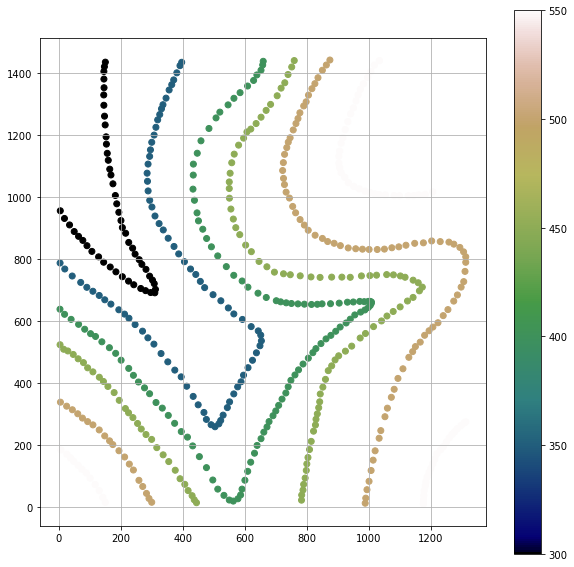

In [6]:
# Plot the contours
fix, ax = plt.subplots(1, figsize=(10, 10))
topo.plot(ax=ax,aspect='equal',column='Z', cmap='gist_earth', legend=True)
plt.grid()

In [7]:
# Interpolate contour lines to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value='Z',method='rbf',res=5)

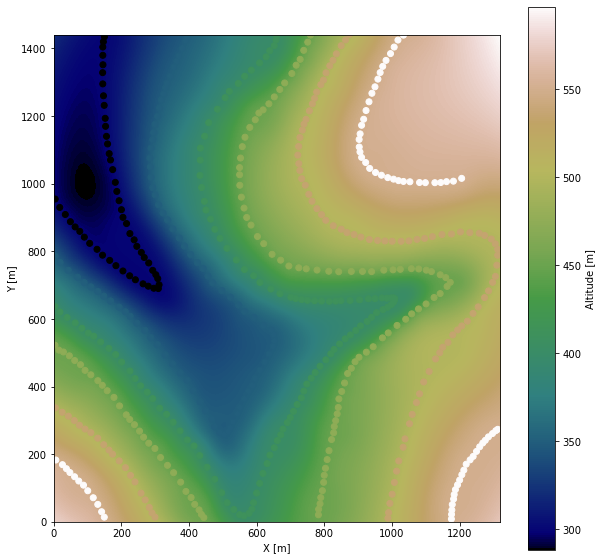

In [8]:
# Plot the DEM
fix, ax = plt.subplots(1, figsize=(10, 10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0, 1320, 0, 1440], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]');

In [9]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path='dem_map2.tif', 
                       extent=[0, 1320, 0, 1440], crs='EPSG:4326', overwrite_file=True)

Raster successfully saved


In [10]:
# Open the DEM from tif file
topo_raster = rasterio.open('dem_map2.tif')

In [11]:
# Read the contacts. These are the bases of the units
contacts = gpd.read_file(current_directory+'/contacts/contacts.shp')
contacts.head()

,X,Y,formation,geometry
0,1185.08,278.16,Q,POINT (1185.079 278.160)
1,1120.59,808.63,Q,POINT (1120.589 808.630)
2,809.94,1218.35,Q,POINT (809.943 1218.354)
3,886.08,204.05,P,POINT (886.081 204.047)
4,780.50,732.19,P,POINT (780.504 732.188)


In [12]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z

,X,Y,formation,geometry,Z
0,1185.08,278.16,Q,POINT (1185.079 278.160),533.29
1,1120.59,808.63,Q,POINT (1120.589 808.630),487.89
2,809.94,1218.35,Q,POINT (809.943 1218.354),514.53
3,886.08,204.05,P,POINT (886.081 204.047),460.82
4,780.50,732.19,P,POINT (780.504 732.188),443.64
5,581.73,1242.06,P,POINT (581.730 1242.064),433.73
6,753.31,344.49,E,POINT (753.308 344.492),409.82
7,264.69,171.66,E,POINT (264.693 171.665),471.78
8,270.87,431.87,D,POINT (270.866 431.872),382.87
9,637.57,656.15,D,POINT (637.572 656.147),380.79


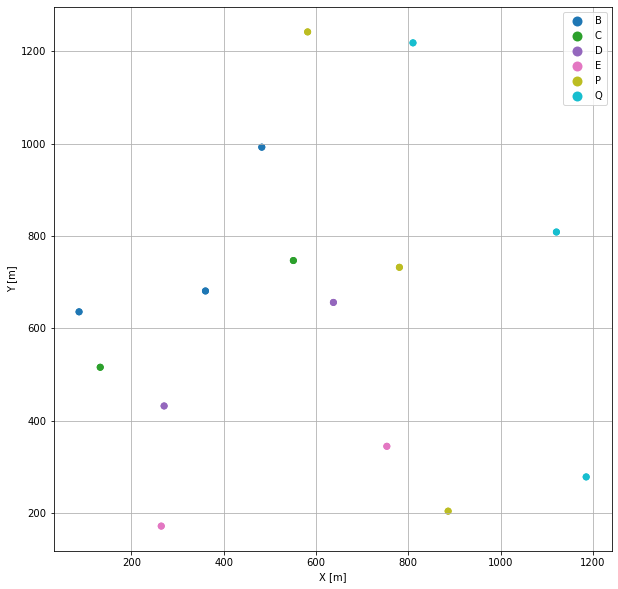

In [13]:
# Plot the points on the contacts
fig, ax = plt.subplots(1, figsize=(10, 10))
contacts.plot(ax=ax, column='formation', legend=True, aspect='equal')
contacts_with_Z.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]');

In [14]:
# Read the points defining the strike lines on the base of D
gdf_D = gpd.read_file(current_directory+'/strike_lines/strike_lines_D.shp')
gdf_D

,X,Y,Z,formation,id,geometry
0,396.10,415.08,350,D,1,POINT (396.097 415.081)
1,629.59,572.15,350,D,1,POINT (629.589 572.154)
2,234.07,436.79,400,D,2,POINT (234.068 436.788)
3,638.68,691.00,400,D,2,POINT (638.677 691.000)
4,84.33,458.39,450,D,3,POINT (84.325 458.387)
5,632.19,809.13,450,D,3,POINT (632.191 809.133)


In [15]:
# Convert the points into strike lines
linestring_gdf_D = gg.vector.create_linestring_gdf(gdf=gdf_D)
linestring_gdf_D

,index,X,Y,Z,formation,id,geometry
0,0,396.10,415.08,350,D,1,"LINESTRING (396.097 415.081, 629.589 572.154)"
1,2,234.07,436.79,400,D,2,"LINESTRING (234.068 436.788, 638.677 691.000)"
2,4,84.33,458.39,450,D,3,"LINESTRING (84.325 458.387, 632.191 809.133)"


In [16]:
# Check that the strike lines on base D are valid
linestring_gdf_D.is_valid

0    True
1    True
2    True
dtype: bool

In [17]:
# Calculate the orientation of the base of D from the strike lines
orientations_D = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_D)
orientations_D

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,27.56,147.40,375.00,POINT (474.608 528.756),1.00,474.61,528.76,D
1,26.81,147.54,425.00,POINT (397.315 598.827),1.00,397.32,598.83,D


In [18]:
# Read the points defining the strike lines at the base of B and P
gdf_B = gpd.read_file(current_directory+'/strike_lines/strike_lines_B.shp')
gdf_P = gpd.read_file(current_directory+'/strike_lines/strike_lines_P.shp')

In [19]:
# Convert points into strike lines
linestring_gdf_B = gg.vector.create_linestring_gdf(gdf=gdf_B)
linestring_gdf_P = gg.vector.create_linestring_gdf(gdf=gdf_P)

In [20]:
# Check that the strike lines on base B and P are valid
linestring_gdf_B.is_valid

0    True
1    True
dtype: bool

In [21]:
linestring_gdf_P.is_valid

0    True
1    True
dtype: bool

In [22]:
# Calculate orientation of the base of B from strike lines
orientations_B = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B)
orientations_B

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,27.36,147.28,375.00,POINT (264.621 745.965),1.00,264.62,745.97,B


In [23]:
# Calculate orientation of the base of P from strike lines
orientations_P = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_P)
orientations_P

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,17.42,66.23,425.00,POINT (728.818 986.082),1.00,728.82,986.08,P


The base of B and the base of D dip 27 degrees to the SE. However, the base of P dips 17 degrees to the NE. The base of P is an unconformity. P and Q lie unconformably over A-E.

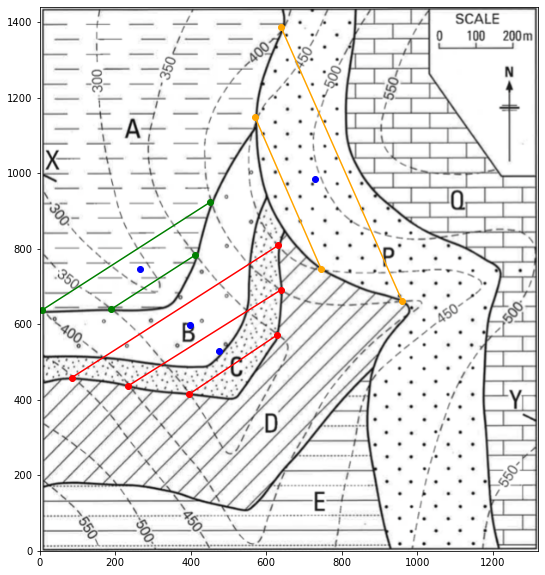

In [24]:
# Plot all this information on the map, the blue dots are orientations
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img, extent=[0, 1320, 0, 1440], cmap='gray')
# base of D
gdf_D.plot(ax=ax, aspect='equal', color='red')
linestring_gdf_D.plot(ax=ax, aspect='equal', color='red')
orientations_D.plot(ax=ax, aspect='equal', color='blue')
# base of B
gdf_B.plot(ax=ax, aspect='equal', color='green')
linestring_gdf_B.plot(ax=ax, aspect='equal', color='green')
orientations_B.plot(ax=ax, aspect='equal', color='blue')
# base of P
gdf_P.plot(ax=ax, aspect='equal', color='orange')
linestring_gdf_P.plot(ax=ax, aspect='equal', color='orange')
orientations_P.plot(ax=ax, aspect='equal', color='blue');

In [25]:
# Merge orientations
import pandas as pd
orientations = pd.concat([orientations_D, orientations_B,orientations_P]).reset_index()
orientations

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,27.56,147.40,375.00,POINT (474.608 528.756),1.00,474.61,528.76,D
1,1,26.81,147.54,425.00,POINT (397.315 598.827),1.00,397.32,598.83,D
2,0,27.36,147.28,375.00,POINT (264.621 745.965),1.00,264.62,745.97,B
3,0,17.42,66.23,425.00,POINT (728.818 986.082),1.00,728.82,986.08,P


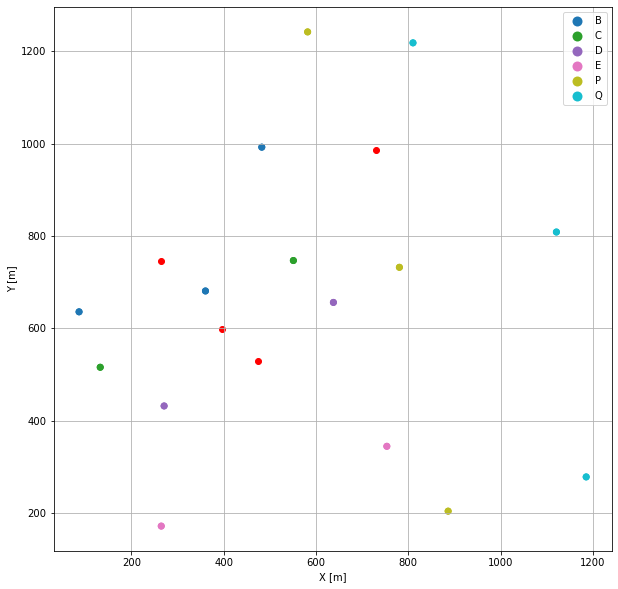

In [26]:
# Plot points on contacts and orientations (red dots)
fig, ax = plt.subplots(1, figsize=(10, 10))
contacts.plot(ax=ax, column='formation', legend=True, aspect='equal')
contacts_with_Z.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]');

# Construction of the model in GemPy

In [27]:
# Import GemPy
import gempy as gp

In [28]:
# Create a geomodel object called model2
geo_model = gp.create_model('model2')

In [29]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 1320, 0, 1440, 0, 1000], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [30]:
# Check default series
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Q,Default series,1,#015482,1
1,P,Default series,2,#9f0052,2
2,E,Default series,3,#ffbe00,3
3,D,Default series,4,#728f02,4
4,C,Default series,5,#443988,5
5,B,Default series,6,#ff3f20,6


In [31]:
# The base of the lowermost unit A does not outcrop in the map
# This unit is our "basement", we add it manually
geo_model.add_surfaces('A')

# The units are divided into 2 series
# Strata1 = units above the unconformity
# Strata2 = units below the unconformity
gp.map_stack_to_surfaces(geo_model, {'Strata1': ('Q', 'P'), 'Strata2': ('E','D', 'C', 'B', 'A'),},
                         remove_unused_series=True)

,surface,series,order_surfaces,color,id
0,Q,Strata1,1,#015482,1
1,P,Strata1,2,#9f0052,2
2,E,Strata2,1,#ffbe00,3
3,D,Strata2,2,#728f02,4
4,C,Strata2,3,#443988,5
5,B,Strata2,4,#ff3f20,6
6,A,Strata2,5,#5DA629,7


In [32]:
# Check the relationships between series
geo_model.stack

,order_series,BottomRelation,isActive,isFault,isFinite
Strata1,1,Erosion,True,False,False
Strata2,2,Erosion,True,False,False


Now we have two different series with their corresponding surfaces. By default, Gempy assigns the unconformity as an erosion.

In [33]:
# Check that the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,Q,Strata1,1,#015482,1,3,0
1,P,Strata1,2,#9f0052,2,3,1
2,E,Strata2,1,#ffbe00,3,2,0
3,D,Strata2,2,#728f02,4,2,2
4,C,Strata2,3,#443988,5,2,0
5,B,Strata2,4,#ff3f20,6,3,1
6,A,Strata2,5,#5DA629,7,0,0


In [34]:
# Set the topography of the model
geo_model.set_topography(source='gdal',filepath='dem_map2.tif');

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [35]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
from pyvistaqt import BackgroundPlotter
gp.plot_3d(geo_model, plotter_type='background',show_topography=True);

In [36]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True, 
                    theano_optimizer='fast_compile');                    

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             2194.54
$C_o$           114666.67
drift equations    [3, 3]


In [37]:
# Ignore warnings from np
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

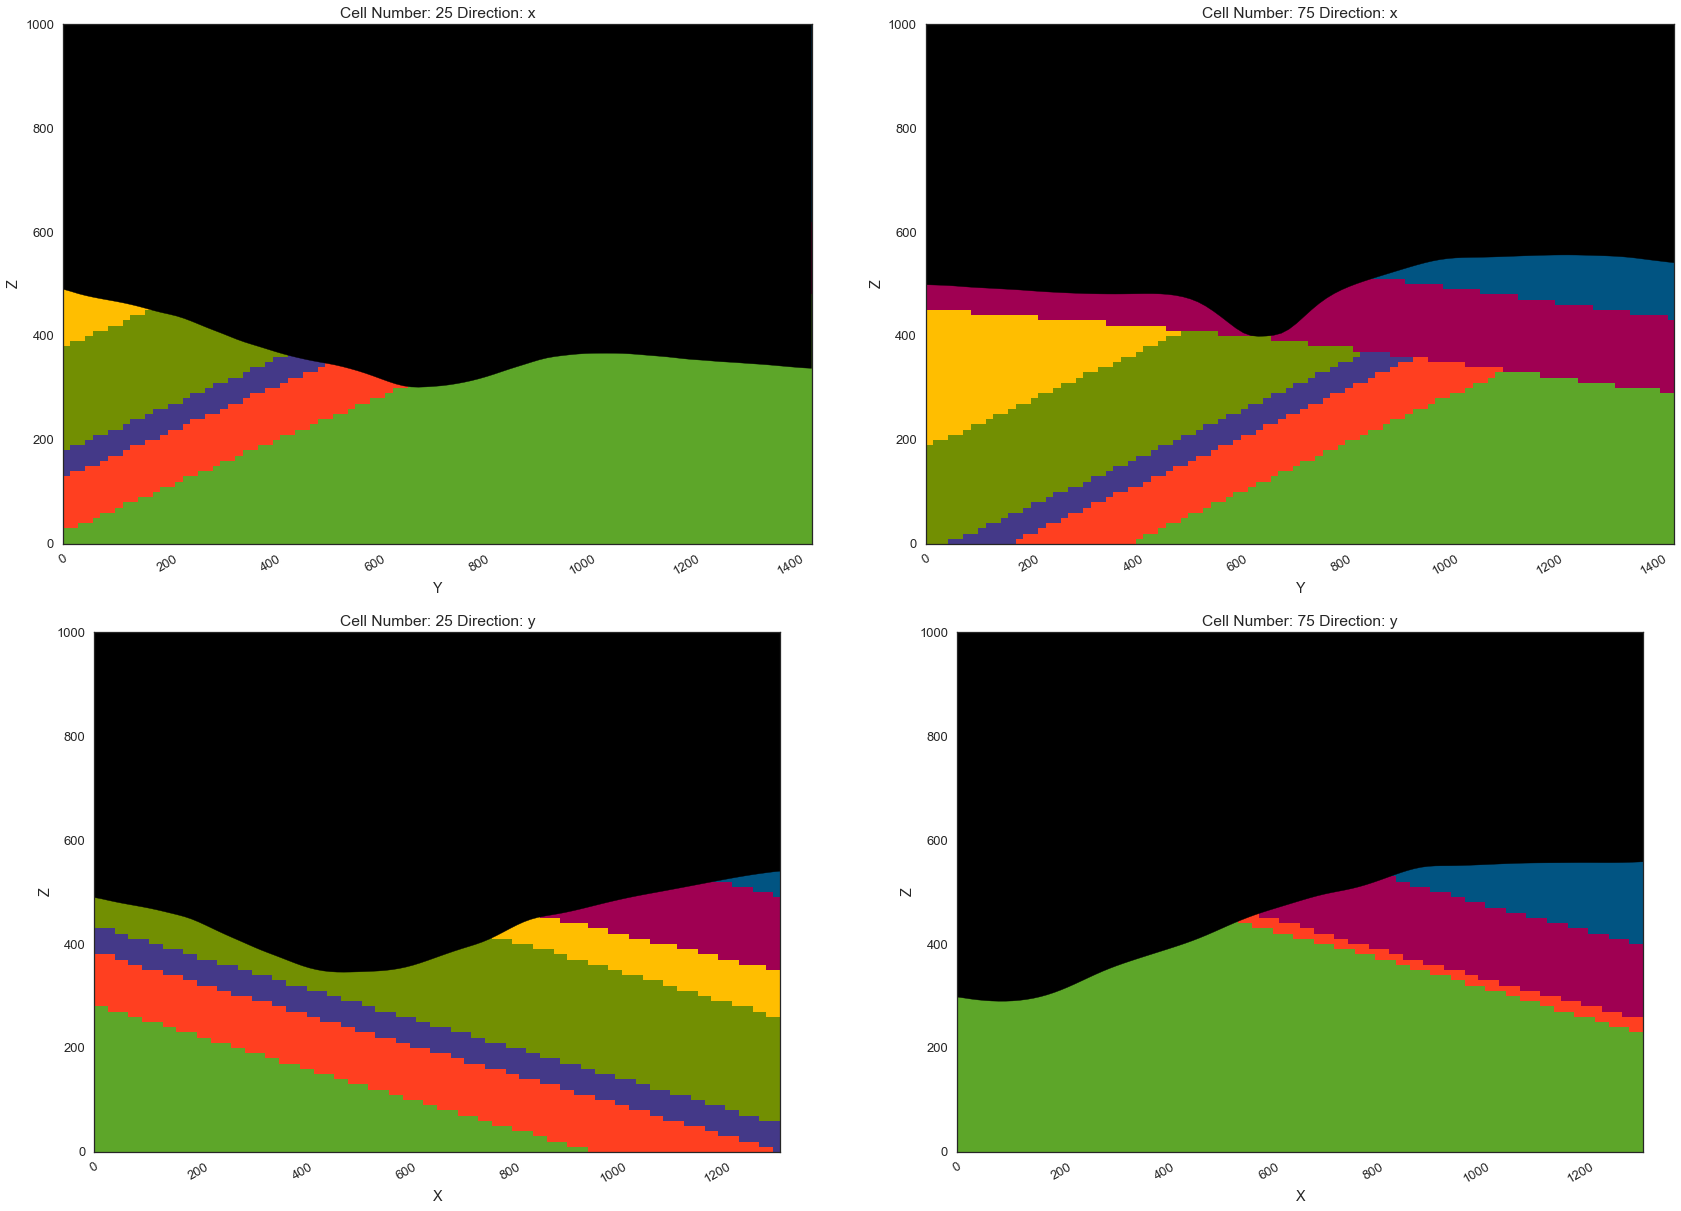

In [38]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25, 75, 25, 75], 
           show_data=False, show_boundaries=False, show_topography=True, show=False);

In [39]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type='background', show_topography=True, show_lith=False);